#### Logistic Regression Exercise - Rain in Australia 
**Dataset Description**: by AUS Bureau of Meteorology; dataset contains about 10 years of daily weather observations from many locations across Australia.

Data card and statistics: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

While the data is on Kaggle, below we'll pull the data from a github repo (URL), for convenice.

**Note**. On purpose, below we'll use only "vanilla" numpy, no pandas for the pre-processing. On the python front, familiarity with list comprehensions may be useful: https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions


In [1]:
import numpy as np 
import csv
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay

response = requests.get('https://raw.githubusercontent.com/gchoi/Dataset/master/weatherAUS.csv')
data = list(csv.reader(response.text.split('\n')))
col_names = data[0]
data = data[1:-1] # ignore last line (it's empty)

float_cols = col_names[2:7] + col_names[8:9] + col_names[11:21] # this is a proof of concept (POC)-> ignore string features for ease
float_data = [x[2:7]+ x[8:9] +  x[11:21] for x in data]
float_data = np.array([[float(y) if y != 'NA' else 0 for y in x] for x in float_data]) #handling NA values

M = float_data[:,:] 
#labels_yes_no = [row[len(row)-1] for row in data] # use this if you want to predict RainTomorrow
labels_yes_no = [row[21] for row in data] # use this if you want to predict RainToday 

l = [float (i=="Yes") for i in labels_yes_no]

print ("number of datapoints:", len(data))
print ("The columns we'll use: ",  float_cols)
print ("Data matrix M, and labels l have dimensions -->", M.shape, len(l))

number of datapoints: 36881
The columns we'll use:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Data matrix M, and labels l have dimensions --> (36881, 16) 36881


In [2]:
# Basic statistics: number of NAs and class distribution
from collections import Counter
from itertools import chain

counter_ob = Counter(chain.from_iterable(data))
print ("Number of NA values: %2d; number of positive examples: %2d; number of negative examples: %2d"\
        % (counter_ob['NA'], l.count(1), l.count(0)))

Number of NA values: 75908; number of positive examples: 8499; number of negative examples: 28382


In [3]:
###### Scale the data: requires zero mean and unit variance
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(M)
M_scaled = scaler.transform(M)

0.9932756703993927
0.9893963627747171
Cross validation scores:  [0.98969911 0.99755965 0.99050976 0.99349241 0.99295011 0.99376356
 0.99213666 0.99186551 0.99105206 0.99322126]


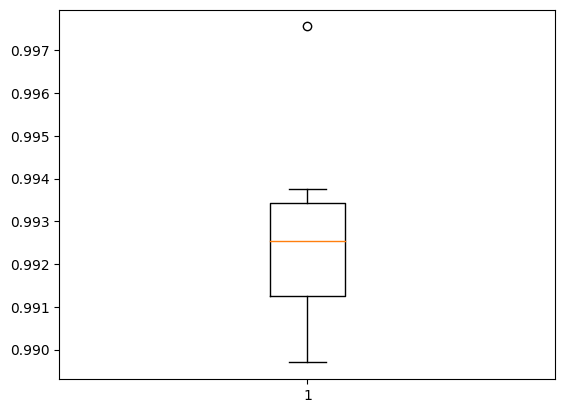

In [4]:
### Sanity test check (not for error estimation but to ensure the data types/dimensions work!)
clf = LogisticRegression()
clf.fit(M_scaled, l)
print (clf.score(M_scaled, l))

### quick test(simple error estimation)
### fit on the first 20K examples, evaluate on the remaining ones; report the accuracy through clf.score
clf = LogisticRegression()
X_train, X_test = M_scaled[:20000], M_scaled[20000:]
y_train, y_test = l[:20000], l[20000:]
clf.fit(X_train, y_train) 
print (clf.score(X_test, y_test))

### Real reporting (rigerous error estimation using cross validation -- more on this later!) 

scores = cross_val_score(clf, M_scaled, l, cv=10)
print("Cross validation scores: ", scores)

#boxplot of the scores to visualize mean and std 
plt.boxplot(scores) 
plt.show()

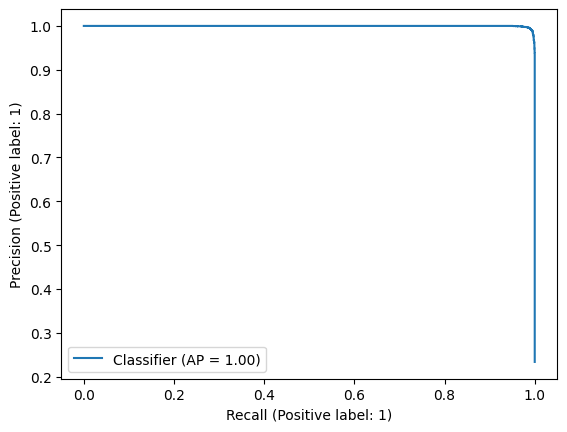

In [5]:
# Let's look at the precision and recall plot -- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

y_pred = clf.predict_proba(M_scaled[20000:])[:, 1]
PrecisionRecallDisplay.from_predictions(l[20000:], y_pred)

**Question 1**

Take a look at the normalization above (using the StandardScaler). Do you notice the error? Think of a way of fixing it and report on the outcome when you fix it, i.e. how does your cross_val_score changes as a result of the change?

In [6]:
# your code/answer

**Question 2**

Can you think of other ways of dealing with the NA values? Implement your idea and report on the result.



**Question 3** 

The above classifier predicts whether it would rain tomorrow. Modify the variable `labels_yes_no` above to instead predict whether it will rain today. 
Report on the outcome, i.e. what's the accuracy? What's the precision and recall plot like? Do the new results make intuitive sense? What could we do?


**Question 4 (Extra)** 

Experiment with different values of the regularization parameter C, e.g. try the following values [.001, .01,.1, .25,.5,1]. 
For use see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

What do you notice? Which one do you think is the most suitable value of the 6?

In [7]:
from sklearn.model_selection import cross_val_score
for i in [.001, .01,.1, .25,.5,1]: 
    clf = LogisticRegression(C=i)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(scores.mean())

0.8634499999999999
0.9217500000000001
0.9627500000000001
0.9756
0.98285
0.98905
